# Exploring MIMIC-IV

Let's explore the data in the MIMIC-IV Waveform Database.

Our **objectives** are to:
- Become familiar with the file structure of the database.
- Find out which signals are present in selected records and segments, and how long the signals last.
- Search for records that contain signals of interest.
- Load waveforms using the WFDB toolbox.
- Plot one minute of signals from a segment of data
- Look more closely at the shape of the PPG pulse waves

<div class="alert alert-block alert-warning">
<p><b>Resource:</b> You can find out more about the MIMIC-IV Waveform Database <a href="https://physionet.org/content/mimic4wdb/0.1.0/">here</a>.</p>
</div>

---
## Setup

### Specify the required Python packages
We'll import the following:
- _sys_: an essential python package
- _pathlib_ (well a particular function from _pathlib_, called _Path_)

In [1]:
import sys
from pathlib import Path

### Specify a particular version of the WFDB Toolbox

- _wfdb_: For this workshop we will be using version 4 of the WaveForm DataBase (WFDB) Toolbox package. The package contains tools for processing waveform data such as those found in MIMIC:

In [3]:
!pip install wfdb==4.1.0
import wfdb

<div class="alert alert-block alert-warning">
<p><b>Resource:</b> You can find out more about the WFDB package <a href="https://physionet.org/content/wfdb-python/3.4.1/">here</a>.</p>
</div>

Now that we have imported these packages (_i.e._ toolboxes) we have a set of tools (functions) ready to use.

### Specify the name of the MIMIC Waveform Database

- Specify the name of the MIMIC IV Waveform Database on Physionet, which comes from the URL: https://physionet.org/content/mimic4wdb/0.1.0/

In [4]:
database_name = 'mimic4wdb/0.1.0'

## Understanding the structure of the database

The waveform database is organized into "records".  Each record represents a single patient and roughly corresponds to a single ICU stay. Each record is stored in a separate subdirectory.

An example of the file structure is shown below.  Here there are two patients (`subject_id` 10014354 and 10039708).  There is one record (81739927) belonging to the first patient, and two records (83411188 and 85583557) belonging to the second. Each record is made of several segments (e.g. record 83411188 is composed of segments: 81739927_0000, 81739927_0001, etc).


```
waves
└── p100
    ├── p10014354
    │   └── 81739927
    │       ├── 81739927.dat
    │       ├── 81739927_0000.hea
    │       ├── 81739927_0001.hea
    │       ├── 81739927_0001e.dat
    │       ├── 81739927_0001r.dat
    │       ├── 81739927_0002.hea
    │       ├── 81739927_0002e.dat
    │       ├── 81739927_0002p.dat
    │       ├── 81739927_0002r.dat
    │       ├── ...
    │       └── 81739927n.csv.gz
    ├── ...
    └── p10039708
        ├── 83411188
        │   ├── 83411188.hea
        │   ├── ...
        │   └── 83411188n.csv.gz
        └── 85583557
            ├── 85583557.hea
            ├── ...
            └── 85583557n.csv.gz
```


_Source: this content is adapted from the [MIMIC WFDB Tutorials](https://wfdb.io/mimic_wfdb_tutorials)._

---
## Identify the records in the database

### Get a list of records

- Use the [`get_record_list`](https://wfdb.readthedocs.io/en/latest/io.html#wfdb.io.get_record_list) function from the WFDB toolbox to get a list of records in the database.

In [5]:
# each subject may be associated with multiple records
subjects = wfdb.get_record_list(database_name)
print(f"The '{database_name}' database contains data from {len(subjects)} subjects")

The 'mimic4wdb/0.1.0' database contains data from 198 subjects


In [6]:
# iterate the subjects to get a list of records
records = []
for subject in subjects:
    studies = wfdb.get_record_list(f'{database_name}/{subject}')
    for study in studies:
        records.append(Path(f'{subject}{study}'))

print(f"Loaded {len(records)} records from the '{database_name}' database.")

Loaded 200 records from the 'mimic4wdb/0.1.0' database.


_NB: There are 200 records for 198 subjects because two subjects had two records (we saw an example of this for subject 10039708 above)._

### Look at the records

- Display the first few records

In [8]:
# format and print first five records
first_five_records = [str(x) for x in records[0:5]]
first_five_records = "\n - ".join(first_five_records)
print(f"First five records: \n - {first_five_records}")

print("""
Note the formatting of these records:
 - intermediate directory ('p100' in this case)
 - subject identifier (e.g. 'p10014354')
 - record identifier (e.g. '81739927'
 """)

First five records: 
 - waves/p100/p10014354/81739927/81739927
 - waves/p100/p10019003/87033314/87033314
 - waves/p100/p10020306/83404654/83404654
 - waves/p100/p10039708/83411188/83411188
 - waves/p100/p10039708/85583557/85583557

Note the formatting of these records:
 - intermediate directory ('p100' in this case)
 - subject identifier (e.g. 'p10014354')
 - record identifier (e.g. '81739927'
 


<div class="alert alert-block alert-info">
<p><b>Q:</b> Can you print the names of the last five records? <br> <b>Hint:</b> in Python, the last five elements can be specified using '[-5:]'</p>
</div>

---
## Extract metadata for a record

Each record contains metadata stored in a header file, named "`<record name>.hea`"

### Specify the online directory containing a record's data

In [9]:
# Specify the 4th record (note, in Python indexing begins at 0)
idx = 3
record = records[idx]
record_dir = f'{database_name}/{record.parent}'
print("PhysioNet directory specified for record: {}".format(record_dir))

PhysioNet directory specified for record: mimic4wdb/0.1.0/waves/p100/p10039708/83411188


### Specify the subject identifier

Extract the record name (e.g. '83411188') from the record (e.g. 'p100/p10039708/83411188/83411188'):

In [10]:
record_name = record.name
print("Record name: {}".format(record_name))

Record name: 83411188


### Load the metadata for this record
- Use the [`rdheader`](https://wfdb.readthedocs.io/en/latest/io.html#wfdb.io.rdheader) function from the WFDB toolbox to load metadata from the record header file

In [11]:
record_data = wfdb.rdheader(record_name, pn_dir=record_dir, rd_segments=True)
remote_url = "https://physionet.org/content/" + record_dir + "/" + record_name + ".hea"
print(f"Done: metadata loaded for record '{record_name}' from the header file at:\n{remote_url}")

Done: metadata loaded for record '83411188' from the header file at:
https://physionet.org/content/mimic4wdb/0.1.0/waves/p100/p10039708/83411188/83411188.hea


---
## Inspect details of physiological signals recorded in this record
- Printing a few details of the signals from the extracted metadata

In [12]:
print(f"- Number of signals: {record_data.n_sig}".format())
print(f"- Duration: {record_data.sig_len/(record_data.fs*60*60):.1f} hours") 
print(f"- Base sampling frequency: {record_data.fs} Hz")

- Number of signals: 6
- Duration: 14.2 hours
- Base sampling frequency: 62.4725 Hz


---
## Inspect the segments making up a record
Each record is typically made up of several segments

In [13]:
segments = record_data.seg_name
print(f"The {len(segments)} segments from record {record_name} are:\n{segments}")

The 6 segments from record 83411188 are:
['83411188_0000', '83411188_0001', '83411188_0002', '83411188_0003', '83411188_0004', '83411188_0005']


The format of filename for each segment is: `record directory, "_", segment number`

---
## Inspect an individual segment
### Read the metadata for this segment
- Read the metadata from the header file

In [20]:
seg_no = 2
segment_metadata = wfdb.rdheader(record_name=segments[seg_no], pn_dir=record_dir)

print(f"""Header metadata loaded for: 
- the segment '{segment_metadata.record_name}'
- in record '{record_name}'
- for subject '{str(Path(record_dir).parent.parts[-1])}'
""")

Header metadata loaded for: 
- the segment '83411188_0002'
- in record '83411188'
- for subject 'p10039708'



### Find out what signals are present

In [21]:
print(f"This segment contains the following signals: {segment_metadata.sig_name}")
print(f"The signals are measured in units of: {segment_metadata.units}")

This segment contains the following signals: ['II', 'V', 'aVR', 'ABP', 'Pleth', 'Resp']
The signals are measured in units of: ['mV', 'mV', 'mV', 'mmHg', 'NU', 'Ohm']


See [here](https://archive.physionet.org/mimic2/mimic2_waveform_overview.shtml#signals-125-samplessecond) for definitions of signal abbreviations.

<div class="alert alert-block alert-info">
<p><b>Q:</b> Which of these signals is no longer present in segment '83411188_0005'?</p>
</div>

### Find out how long each signal lasts

All signals in a segment are time-aligned, measured at the same sampling frequency, and last the same duration:

In [22]:
print(f"The signals have a base sampling frequency of {segment_metadata.fs:.1f} Hz")
print(f"and they last for {segment_metadata.sig_len/(segment_metadata.fs*60):.1f} minutes")

The signals have a base sampling frequency of 62.5 Hz
and they last for 0.9 minutes


## Identify records suitable for analysis

- The signals and their durations vary from one record (and segment) to the next. 
- Since most studies require specific types of signals (e.g. blood pressure and photoplethysmography signals), we need to be able to identify which records (or segments) contain the required signals and duration.

### Setup

In [24]:
print(f"Earlier, we loaded {len(records)} records from the '{database_name}' database.")

Earlier, we loaded 200 records from the 'mimic4wdb/0.1.0' database.


### Specify requirements

- Required signals

In [25]:
required_sigs = ['ABP', 'Pleth']

- Required duration

In [26]:
# convert from minutes to seconds
req_seg_duration = 10*60 

### Find out how many records meet the requirements

_NB: This step may take a while. The results are copied below to save running it yourself._

In [19]:
matching_recs = {'dir':[], 'seg_name':[], 'length':[]}

for record in records:
    print('Record: {}'.format(record), end="", flush=True)
    record_dir = f'{database_name}/{record.parent}'
    record_name = record.name
    print(' (reading data)')
    record_data = wfdb.rdheader(record_name,
                                pn_dir=record_dir,
                                rd_segments=True)

    # Check whether the required signals are present in the record
    sigs_present = record_data.sig_name
    if not all(x in sigs_present for x in required_sigs):
        print('   (missing signals)')
        continue

    # Get the segments for the record
    segments = record_data.seg_name

    # Check to see if the segment is 10 min long
    # If not, move to the next one
    gen = (segment for segment in segments if segment != '~')
    for segment in gen:
        print(' - Segment: {}'.format(segment), end="", flush=True)
        segment_metadata = wfdb.rdheader(record_name=segment,
                                         pn_dir=record_dir)
        seg_length = segment_metadata.sig_len/(segment_metadata.fs)

        if seg_length < req_seg_duration:
            print(f' (too short at {seg_length/60:.1f} mins)')
            continue

        # Next check that all required signals are present in the segment
        sigs_present = segment_metadata.sig_name
        
        if all(x in sigs_present for x in required_sigs):
            matching_recs['dir'].append(record_dir)
            matching_recs['seg_name'].append(segment)
            matching_recs['length'].append(seg_length)
            print(' (met requirements)')
            # Since we only need one segment per record break out of loop
            break
        else:
            print(' (long enough, but missing signal(s))')

print(f"A total of {len(matching_recs['dir'])} records met the requirements:")

# import pandas as pd
#df_matching_recs = pd.DataFrame(data=matching_recs)
#df_matching_recs.to_csv('matching_records.csv', index=False)
#p=1

Record: waves/p100/p10014354/81739927/81739927 (reading data)
   (missing signals)
Record: waves/p100/p10019003/87033314/87033314 (reading data)
   (missing signals)
Record: waves/p100/p10020306/83404654/83404654 (reading data)
 - Segment: 83404654_0000 (too short at 0.0 mins)
 - Segment: 83404654_0001 (long enough, but missing signal(s))
 - Segment: 83404654_0002 (too short at 0.1 mins)
 - Segment: 83404654_0003 (too short at 0.3 mins)
 - Segment: 83404654_0004 (long enough, but missing signal(s))
 - Segment: 83404654_0005 (met requirements)
Record: waves/p100/p10039708/83411188/83411188 (reading data)
 - Segment: 83411188_0000 (too short at 0.0 mins)
 - Segment: 83411188_0001 (too short at 0.1 mins)
 - Segment: 83411188_0002 (too short at 0.9 mins)
 - Segment: 83411188_0003 (too short at 0.3 mins)
 - Segment: 83411188_0004 (too short at 0.3 mins)
 - Segment: 83411188_0005 (long enough, but missing signal(s))
Record: waves/p100/p10039708/85583557/85583557 (reading data)
   (missing si

 - Segment: 81741333_0012 (too short at 0.0 mins)
 - Segment: 81741333_0013 (too short at 0.0 mins)
 - Segment: 81741333_0014 (too short at 0.1 mins)
 - Segment: 81741333_0015 (long enough, but missing signal(s))
Record: waves/p124/p12449182/84179115/84179115 (reading data)
   (missing signals)
Record: waves/p124/p12470697/84213440/84213440 (reading data)
   (missing signals)
Record: waves/p125/p12545470/80674263/80674263 (reading data)
   (missing signals)
Record: waves/p125/p12563752/85393521/85393521 (reading data)
   (missing signals)
Record: waves/p125/p12567919/82552643/82552643 (reading data)
   (missing signals)
Record: waves/p127/p12789108/85835247/85835247 (reading data)
   (missing signals)
Record: waves/p128/p12801061/80154334/80154334 (reading data)
   (missing signals)
Record: waves/p128/p12807320/81739815/81739815 (reading data)
   (missing signals)
Record: waves/p128/p12847457/83054955/83054955 (reading data)
   (missing signals)
Record: waves/p128/p12872596/85230771/85

Record: waves/p150/p15030787/82582002/82582002 (reading data)
   (missing signals)
Record: waves/p151/p15174162/89866183/89866183 (reading data)
 - Segment: 89866183_0000 (too short at 0.0 mins)
 - Segment: 89866183_0001 (too short at 0.2 mins)
 - Segment: 89866183_0002 (too short at 0.1 mins)
 - Segment: 89866183_0003 (too short at 0.0 mins)
 - Segment: 89866183_0004 (too short at 3.0 mins)
 - Segment: 89866183_0005 (too short at 0.0 mins)
 - Segment: 89866183_0006 (too short at 0.1 mins)
 - Segment: 89866183_0007 (too short at 0.0 mins)
 - Segment: 89866183_0008 (too short at 0.1 mins)
 - Segment: 89866183_0009 (too short at 0.2 mins)
 - Segment: 89866183_0010 (too short at 0.1 mins)
 - Segment: 89866183_0011 (too short at 0.0 mins)
 - Segment: 89866183_0012 (too short at 0.0 mins)
 - Segment: 89866183_0013 (too short at 0.0 mins)
 - Segment: 89866183_0014 (met requirements)
Record: waves/p153/p15312343/89068160/89068160 (reading data)
 - Segment: 89068160_0000 (too short at 0.0 mins

 - Segment: 80666640_0014 (met requirements)
Record: waves/p179/p17973277/83801243/83801243 (reading data)
 - Segment: 83801243_0000 (too short at 0.0 mins)
 - Segment: 83801243_0001 (too short at 0.6 mins)
 - Segment: 83801243_0002 (too short at 0.2 mins)
 - Segment: 83801243_0003 (too short at 4.0 mins)
 - Segment: 83801243_0004 (too short at 0.1 mins)
 - Segment: 83801243_0005 (too short at 0.0 mins)
 - Segment: 83801243_0006 (too short at 0.9 mins)
 - Segment: 83801243_0007 (long enough, but missing signal(s))
 - Segment: 83801243_0008 (too short at 8.2 mins)
 - Segment: 83801243_0009 (long enough, but missing signal(s))
 - Segment: 83801243_0010 (long enough, but missing signal(s))
 - Segment: 83801243_0011 (too short at 0.8 mins)
 - Segment: 83801243_0012 (long enough, but missing signal(s))
 - Segment: 83801243_0013 (too short at 0.1 mins)
 - Segment: 83801243_0014 (long enough, but missing signal(s))
 - Segment: 83801243_0015 (too short at 0.1 mins)
 - Segment: 83801243_0016 (l

In [24]:
print(f"A total of {len(matching_recs['dir'])} out of {len(records)} records met the requirements.")

relevant_segments_names = "\n - ".join(matching_recs['seg_name'])
print(f"\nThe relevant segment names are:\n - {relevant_segments_names}")

relevant_dirs = "\n - ".join(matching_recs['dir'])
print(f"\nThe corresponding directories are: \n - {relevant_dirs}")

A total of 52 out of 200 records met the requirements.

The relevant segment names are:
 - 83404654_0005
 - 82924339_0007
 - 84248019_0005
 - 82439920_0004
 - 82800131_0002
 - 84304393_0001
 - 89464742_0001
 - 88958796_0004
 - 88995377_0001
 - 85230771_0004
 - 86643930_0004
 - 81250824_0005
 - 87706224_0003
 - 83058614_0005
 - 82803505_0017
 - 88574629_0001
 - 87867111_0012
 - 84560969_0001
 - 87562386_0001
 - 88685937_0001
 - 86120311_0001
 - 89866183_0014
 - 89068160_0002
 - 86380383_0001
 - 85078610_0008
 - 87702634_0007
 - 84686667_0002
 - 84802706_0002
 - 81811182_0004
 - 84421559_0005
 - 88221516_0007
 - 80057524_0005
 - 84209926_0018
 - 83959636_0010
 - 89989722_0016
 - 89225487_0007
 - 84391267_0001
 - 80889556_0002
 - 85250558_0011
 - 84567505_0005
 - 85814172_0007
 - 88884866_0005
 - 80497954_0012
 - 80666640_0014
 - 84939605_0004
 - 82141753_0018
 - 86874920_0014
 - 84505262_0010
 - 86288257_0001
 - 89699401_0001
 - 88537698_0013
 - 83958172_0001

The corresponding directori

<div class="alert alert-block alert-info">
<p><b>Question:</b> Is this enough data for a study? Consider different types of studies, e.g. assessing the performance of a previously proposed algorithm to estimate BP from the PPG signal, vs. developing a deep learning approach to estimate BP from the PPG.</p>
</div>

## Extract data for a segment

- Provide a list of segments which meet the requirements for the study

In [27]:
segment_names = ['83404654_0005', '82924339_0007']
segment_dirs = ['mimic4wdb/0.1.0/waves/p100/p10020306/83404654',
                'mimic4wdb/0.1.0/waves/p101/p10126957/82924339']

- Specify a segment from which to extract data

In [28]:
rel_segment_no = 0
rel_segment_name = segment_names[rel_segment_no]
rel_segment_dir = segment_dirs[rel_segment_no]
print(f"Specified segment '{rel_segment_name}' in directory: '{rel_segment_dir}'")

Specified segment '83404654_0005' in directory: 'mimic4wdb/0.1.0/waves/p100/p10020306/83404654'


<div class="alert alert-block alert-info">
<p><b>Extension:</b> Have a look at the files which make up this record <a href="https://physionet.org/content/mimic4wdb/0.1.0/waves/p100/p10020306/">here</a> (NB: you will need to scroll to the bottom of the page).</p>
</div>

- Use the [`rdrecord`](https://wfdb.readthedocs.io/en/latest/io.html#wfdb.io.rdrecord) function from the WFDB toolbox to read the data for this segment.

In [29]:
segment_data = wfdb.rdrecord(record_name=rel_segment_name, pn_dir=rel_segment_dir) 
print(f"Data loaded from segment: {rel_segment_name}")

Data loaded from segment: 83404654_0005


- Look at class type of the object in which the data are stored:

In [30]:
print(f"Data stored in class of type: {type(segment_data)}")

Data stored in class of type: <class 'wfdb.io.record.Record'>


<div class="alert alert-block alert-warning">
<p><b>Resource:</b> You can find out more about the class representing single segment WFDB records <a href="https://wfdb.readthedocs.io/en/stable/io.html?highlight=class#wfdb.io.Record">here</a>.</p>
</div>

- Find out about the signals which have been extracted

In [31]:
print(f"This segment contains waveform data for the following {segment_data.n_sig} signals: {segment_data.sig_name}")
print(f"The signals are sampled at a base rate of {segment_data.fs} Hz (and some are sampled at multiples of this)")
print(f"They last for {segment_data.sig_len/(60*segment_data.fs):.1f} minutes")

This segment contains waveform data for the following 6 signals: ['II', 'V', 'aVR', 'ABP', 'Pleth', 'Resp']
The signals are sampled at a base rate of 62.4725 Hz (and some are sampled at multiples of this)
They last for 52.4 minutes


<div class="alert alert-block alert-info">
<p><b>Question:</b> Can you find out which signals are sampled at multiples of the base sampling frequency by looking at the following contents of the 'segment_data' variable?</p>
</div>

In [32]:
vars(segment_data)

{'record_name': '83404654_0005',
 'n_sig': 6,
 'fs': 62.4725,
 'counter_freq': 999.56,
 'base_counter': 10219520.0,
 'sig_len': 196480,
 'base_time': None,
 'base_date': None,
 'comments': ['signal 0 (II): channel=0 bandpass=[0.5,35]',
  'signal 1 (V): channel=1 bandpass=[0.5,35]',
  'signal 2 (aVR): channel=2 bandpass=[0.5,35]'],
 'sig_name': ['II', 'V', 'aVR', 'ABP', 'Pleth', 'Resp'],
 'p_signal': array([[ 0.00000000e+00, -6.50000000e-02, -5.00000000e-03,
                     nan,  5.02929688e-01,  1.56120205e-01],
        [ 5.00000000e-03, -4.50000000e-02, -5.00000000e-03,
                     nan,  5.02929688e-01,  1.56853164e-01],
        [ 1.50000000e-02, -2.50000000e-02,  5.00000000e-03,
                     nan,  5.02929688e-01,  1.57097484e-01],
        ...,
        [-1.50000000e-02,  7.00000000e-02, -4.00000000e-02,
          7.25000000e+01,  5.74951172e-01,  3.57683850e-01],
        [-1.50000000e-02,  5.50000000e-02, -4.50000000e-02,
          7.25000000e+01,  5.70800781e-01

## Visualise the signals

### Select a segment

- Specify a segment from which to extract data

In [33]:
rel_segment_n = 1
rel_segment_name = segment_names[rel_segment_n]
rel_segment_dir = segment_dirs[rel_segment_n]
print(f"Specified segment '{rel_segment_name}' in directory: '{rel_segment_dir}'")

Specified segment '82924339_0007' in directory: 'mimic4wdb/0.1.0/waves/p101/p10126957/82924339'


### Extract one minute of data from this segment

- Specify the timings of the data to be extracted

In [34]:
# time since the start of the segment at which to begin extracting data
start_seconds = 20
n_seconds_to_load = 60

- Find out the sampling frequency of the waveform data

In [35]:
segment_metadata = wfdb.rdheader(record_name=rel_segment_name,
                                 pn_dir=rel_segment_dir)

print(f"Metadata loaded from segment: {rel_segment_name}")
fs = round(segment_metadata.fs)

Metadata loaded from segment: 82924339_0007


- Extract the specified data

In [36]:
sampfrom = fs * start_seconds
sampto = fs * (start_seconds + n_seconds_to_load)

segment_data = wfdb.rdrecord(record_name=rel_segment_name,
                             sampfrom=sampfrom,
                             sampto=sampto,
                             pn_dir=rel_segment_dir)

print(f"{n_seconds_to_load} seconds of data extracted from segment {rel_segment_name}")

60 seconds of data extracted from segment 82924339_0007


### Plot the extracted signals

- Plot the extracted signals using the [plot_wfdb](https://wfdb.readthedocs.io/en/latest/plot.html#wfdb.plot.plot_wfdb) function from the WFDB Toolbox.

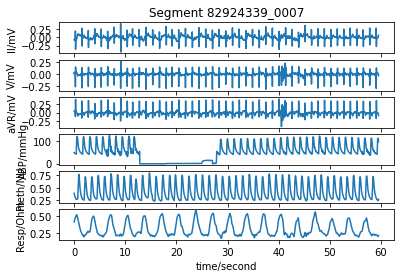

In [37]:
title_text = f"Segment {rel_segment_name}"
wfdb.plot_wfdb(record=segment_data,
               title=title_text,
               time_units='seconds') 

- Extract the PPG signal to loook at it more closely

In [38]:
for sig_no in range(0, len(segment_data.sig_name)):
    if "Pleth" in segment_data.sig_name[sig_no]:
        break

ppg = segment_data.p_signal[:, sig_no]
fs = segment_data.fs
print(f"Extracted the PPG signal from column {sig_no} of the matrix of waveform data.")

Extracted the PPG signal from column 4 of the matrix of waveform data.


<div class="alert alert-block alert-warning"><p><b>Note:</b> the name given to PPG signals in the database is 'Pleth'.</p></div>

- Plot to look at the shape of the PPG pulse wave more closely

(50.0, 55.0)

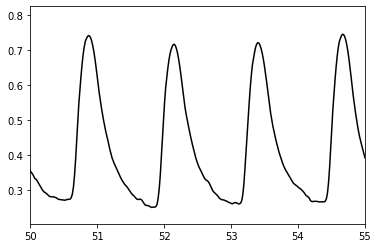

In [39]:
from matplotlib import pyplot as plt
import numpy as np

t = np.arange(0, (len(ppg) / fs), 1.0 / fs)
plt.plot(t, ppg, color = 'black', label='PPG')
plt.xlim([50, 55])

### Compare this to pulse waves from the literature

- Compare the pulse waves above to the different shapes of pulse waves shown here:

![PPG pulse waves](https://upload.wikimedia.org/wikipedia/commons/e/ed/Classes_of_photoplethysmogram_%28PPG%29_pulse_wave_shape.svg)

Source: _Charlton PH et al., 'Assessing hemodynamics from the photoplethysmogram to gain insights into vascular age: a review from VascAgeNet', https://doi.org/10.1152/ajpheart.00392.2021 (CC BY 4.0)_

These pulse waves are the typical shapes for young (class 1) to old (class 4) subjects.

<div class="alert alert-block alert-info"><p><b>Question:</b> How do these pulse waves compare to those extracted from the MIMIC Database? Which is most similar?</p></div>